<a href="https://colab.research.google.com/github/damiencolas/testing/blob/main/Test_Computing_CheckMeO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse Capteur Risque Apnée du Sommeil
---


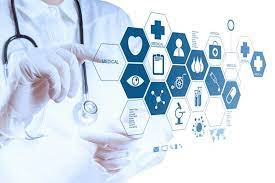

# MODULES et FONCTIONS

In [ ]:
#@title
# importing modules 
import shutil
import csv #gestion des csv
from csv import writer
from csv import DictWriter
from IPython.display import display #module de visualition des data a l'ecran
import numpy as np # structures de array facilite les calculs
import pandas as pd # structures de données pratiques pour description et graphing
from scipy.signal import find_peaks #module de math et traitement du signal
import plotly.graph_objects as go # graphing d'objets et interface dynamique
from plotly.subplots import make_subplots
import glob #repère les patterns de naming
from pathlib import Path #gère les noms de fichiers et les paths
import os #gere chgt de noms de fichiers si besoin
from datetime import datetime #gestion des dates et heures
from time import time, ctime, struct_time
from dateutil.parser import parse #gestion date/time
from IPython.display import Markdown, display #permet de outprinter en markdown
from random import randint #generation de nombres aleatoires (utiliser seed() pour generer toujours la meme sequence)
from operator import add #operateurs sur les methodes map
import matplotlib.pyplot as plt #graphing
import matplotlib.ticker as plticker
from matplotlib.patches import Circle, Rectangle, Ellipse
from matplotlib.patches import FancyBboxPatch
import seaborn as sns #graphing statistique

from PIL import Image #manipulation d'images

#convertion des secondes en heures et minutes
def convert(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    if hour == 0 :  
      return "%02d" % (minutes)
    else :
      return "%dh%02d" % (hour, minutes)

# Dictionnaires :
def append_dict_as_row(file_name, dict_of_elem, field_names):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        dict_writer = DictWriter(write_obj, fieldnames=field_names)
        # Add dictionary as wor in the csv
        dict_writer.writerow(dict_of_elem)

#_Fonction pour positiver les variabilités basees sur des differences entre points
def A(x):
  return abs(x)

# fonctions spécifiques d'affichage:
def printmd(string):
    display(Markdown(string)) #printer en markdown

pd.options.display.float_format = '{:,.1f}'.format #les float des DF seront printees avec 1 decimal
%load_ext google.colab.data_table

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Full workflow 2 jours ring or check-max

## Formatage | Calculs | Scoring visuel |Figures
**revoir les calculs et seuillages !!**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


['202209132242', '202209142204']


**Calculs : Moyennes et Sommes (et autres features) sur 1 minute**

**_GRAPHING en 1 min par axe_**



quel est le bin minute de la latence de sommeil ? 7
quel est le bin minute de la fin de sommeil ? 526
quel est le seuil minute de lactivité ? 10






quel est le bin minute de la latence de sommeil ? 7
quel est le bin minute de la fin de sommeil ? 525
quel est le seuil minute de lactivité ? 10


[7, 7]
[526, 525]
[10, 10]


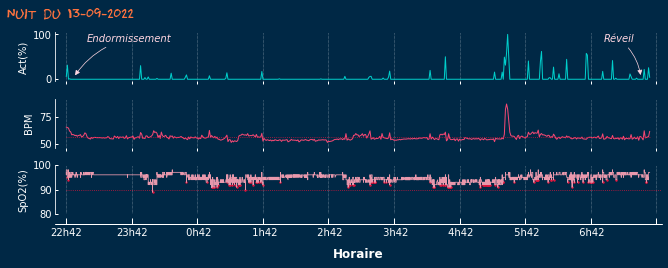

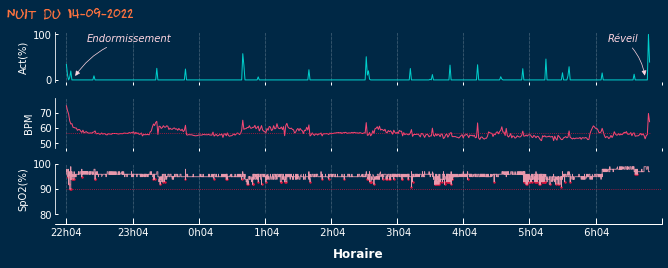



DONEDONE


**Pour la suite :**

bins de debut et fin; seuils
[7, 7]
[526, 525]
[10, 10]
DONE


In [ ]:
# VERIFIER que les nom des colonne originale du
#@title
# dossier :
nom ='test'
#nom = str(input('Quel est le dossier à traiter ? '))
# seuil de desat
sp = 3
#sp = int(input("quel est le seuil à appliquer ? "))
#dossier des raw data intiales: 2 records 
recup = 'o' #scorer les seuils/latences ?
#recup = str(input('Faut-il scorer manuèlement ? o/n '))
capteur = 'max' #'ring' #'checkme_max' 'old_checkme'
#folder_initial = f'/content/drive/MyDrive/fichiers_à_analyser/{nom}'
folder_initial = f'/content/drive/MyDrive/Activité-Pro/Health_Consulting/{nom}'

#creer les directory dans drive !! a executer une seule fois par notebook, sinon supprimer du drive
#os.makedirs('/content/drive/My Drive/PROJET ANALYSES CSV OXYMETRIE ACTIMETRIE/CSV_Originaux')
#os.makedirs('/content/drive/My Drive/CSV_CLEANÉS_ET_EN_1MIN_PIC-SPO2')

#date et heure du jour
now = datetime.now() #recupere la date et heure du moment en time stamp python (secondes depuis 1970 etc...)
current_time = now.strftime("%D %H:%M:%S") #transforme date et heure en str lisible

#Récupérer et renommer les fichiers originaus du Drive
IDs = [] #au format date-heure de debut d'enregistrement
# Faire un ID parametrable avec pattern recognition sinon a chaque changement de folder le naming tombe mal
h=folder_initial+'/*OXIRecord.csv'
paths=sorted(glob.glob(h)) #recupere la liste des paths de fichiers d'interet, indiquer le directory puis le pattern a trouver
for N in paths:
  if capteur == 'ring' : IDs.append(N[69:-16])
  if capteur == 'max' : IDs.append(N[68:-16])
print(IDs)

#creer les directory dans drive !! a executer une seule fois par notebook, sinon supprimer du drive
#os.makedirs('/content/drive/My Drive/PROJET ANALYSES CSV OXYMETRIE ACTIMETRIE/CSV_Originaux')
#os.makedirs('/content/drive/My Drive/CSV_CLEANÉS_ET_EN_1MIN_PIC-SPO2')



# Formatage initial :
excludeddataframes = []
dataframesCheck4s = []
for i in range(len(paths)):     
  DF1=pd.read_csv(paths[i], header=0, parse_dates=[0], index_col=0,squeeze=True) #creation des Df de csv   
  index_list = DF1.index.tolist()
  DF1['TI'] = index_list #rajoute le temps comme colonne TI (time-stamps si besoin graphing)
  DF1['Motion'] = DF1['Mouvement'] #depending on actual naming
  DF2=DF1.drop(['SpO2 Reminder'], axis=1) 
  DF2=DF2.drop(['PR Reminder'], axis=1)
  DF3=DF2.rename(columns={'SpO2(%)':'SpO2'}) 
  #DF4=DF3.rename(columns={'Rythme cardiaque':'Pulse Rate '}) 
  DF4=DF3.rename(columns={'Fré. pouls':'Pulse Rate'})
  DF5=DF4.rename_axis('Time')
  DF6=DF5.replace(to_replace =65535, value =70) #differentes syntaxt pour remplacer des valeurs fixes dans des DF et colomnes
  DF7=DF6.replace(to_replace =255, value =97) 
  #SMOOTHING :
  DF7['Motion']= DF7['Motion'].replace([1],0) 
  DF7['Motion']= DF7['Motion'].replace([2],0)
  
  #ici Fonction du capteur: les valeurs d'activités en dessous de 1 par 4s sont eliminees car non specifiques (ou alors mvt de respi)
  #DF6['Motion'].where(~(DF6.Motion <= 2), other=0, inplace=True)  #! a verifier la fonction where semble mofifier l'original aussi. 
  t=DF7.dtypes['TI']  
  if t!='datetime64[ns]':
    print(filesnumberCheck[i] + ' attention pas datetime  ')
    excludeddataframes.append(IDs[i])
  dataframesCheck4s.append(DF7) #dataframes est la liste des data frames initiaux de travail

#--> ainsi les fichiers de travail sont sous forme de DF cleanés avec les noms simplifiés date-heure-REC , filtrés pour activités <=2
if len(excludeddataframes) > 0 :
  printmd('**DF exclus pour cause de time-stamp :')
  print(excludeddataframes)


# CALCULS

#for i in range(len(paths)):     
  #DF1=pd.read_csv(paths[i], header=0, parse_dates=[0,4], index_col=0,squeeze=True) #creation des Df de csv    
  #dataframesCheck4s.append(DF1) #dataframes est la liste des data frames initiaux de travail

#_IIa- Traitement du signal 
#Downslampings et export des dataframes en 1 ou plus minute selon la moyenne ou la somme (verifier si ca s'applique a droite ou a gauche avec les time stamps)
#__moyennes:
printmd('**Calculs : Moyennes et Sommes (et autres features) sur 1 minute**')
print('\n')
dataframesCheck1minmoy=[]

for N in dataframesCheck4s:  
  N=N.resample('T').mean()    #le resampling se fait sur des index type time-stamps
  N=N.reset_index()           #pour le graphing il faut une colonne Time
  dataframesCheck1minmoy.append(N)  


#__sommes:
#printmd('**Sommes**')

dataframesCheck1minsum=[]

for N in dataframesCheck4s:
  N=N.resample('T').sum()
  N=N.reset_index() #pour le graphing il faut une colonne Time
  dataframesCheck1minsum.append(N)

# autres features en vue de la modelisation machine learning : a compléter
# VARIABILITE : VARIANCE ou variance sur la diference ?
dataframesCheck1minvar=[]

for N in dataframesCheck4s:
  N = N.diff(periods=1) #calcul de la difference bin a bin 
  N = N.abs()
  N=N.resample('T').sum() #var
  N=N.reset_index() #pour le graphing il faut une colonne Time
  dataframesCheck1minvar.append(N)



# Traitement du signal pour la detection des desaturations
#_A- CALCUL DES PICS :
#_1- Les index doivent etre resetés 

dataframesCheck4s_reset=[] #la liste des DF avec index resete (recupere une colonne time)

for DF in dataframesCheck4s:
  DF=DF.reset_index()
  dataframesCheck4s_reset.append(DF)

#_2- Recuperation des serie pour le calcul des pics dans une liste
seriesSPO2=[] #liste des colonnes SpO2
for df in dataframesCheck4s:    
  S=df['SpO2']
  seriesSPO2.append(S)

#_3- calcul des pics en nd array (ce sont des positions (index) de la serie de valeurs SPO2)
#p=int(input('choisir une prominence de pic (typiquement=4): '))
p = sp
PICSPO2=[] # liste des nd arrays contenant les positions des pics SpO2 au pas de 4s
for i in range(len(seriesSPO2)):
  S=seriesSPO2[i]
  #X=filesnumberCheck[i]
  #fullX='{}_PICSPO2'.format(X) #a faire: prendre en compte la distance en tp entre deux pics qui ne peut pas etre trop courte
  fullX = find_peaks(-S,threshold=0,height=(None,None),prominence=(p,None))[0]
  PICSPO2.append(fullX)

#_4- Insertion des pic correctement dans les DF REC
PIC_vPS=[] #une liste qui contiendra les series de PIC SPO2 bien positionnés (valeur aux pics intercallés de NaN)

#__4.1-running a for loop and asigning some values to series PICPD FOR EACH DF-RECS : ilva falloir les enregistrer quelque part (ds PICS)
for j in range(len(IDs)):
    PIC = pd.Series([float]) # creating a blank pandas series pour l'integration du fichiers PIC au DF REC (ici il faudrait iterer avec des listes plutot que pd mais solution non trouvee)
    for i in range(len(seriesSPO2[j])): 
        if i in PICSPO2[j]: 
          PIC[i]= seriesSPO2[j][i]        
        else:         
          PIC[i]='NaN'
    PIC_vPS.append(PIC)

#__4.2- inserting new column with values of list made above         
REC_PIC=[] #liste des series de PIC avec Time=colone
for j in range(len(IDs)): 
  A=pd.concat([dataframesCheck4s_reset[j], PIC_vPS[j]], axis=1)
  A.rename(columns={0: 'PIC-SPO2'},inplace=True)
  REC_PIC.append(A)
  


 

# POUR PLUS TARD :
#_3- Nombres de transitions sur les DF sur une minute: definition differente pour activité (discrete) vs Fc/SpO2(continue) :
# _3.1- FINALISER PLUS TARD :a chaque fois qu'une diff abs de periode 1 n'est pas nulle = "transition" pour SpO2 Pulse Rate
#3.1-Bis Motion: une transition = chaque fois qu'il y a une activation de 4s sur la minute
dataframesCheckTRANSitions_1=[] #DF sur l'existence de tranition sur les Diff periode 1 time-stamp
dataframesCheckTRANSitions_1_graph=[] #avec index reseter pour avoir une colonne time pour graphing

N=pd.DataFrame()
for N in dataframesCheck4s:
  conditions = [
      (N['Motion'] > 0)
      #(df['Motion'] >200) & (df['Motion'] <= 300),
      #(df['Motion'] > 0) & (df['Motion'] <= 20),
      ]
  values = [1]
  N['TRANS'] = np.select(conditions, values)
  dataframesCheckTRANSitions_1.append(N)
  N=N.reset_index()
  dataframesCheckTRANSitions_1_graph.append(N)

#_3.2- Avec les data sur une minute: Moyennes, ou sommes, ou facteur scalaire de la data moy sur 1min
#_3.2.1- Nombre de transitions par minute (somme)
dataframesCheckTRANSsum1min_1=[] # DF nombre de transitions sur la minute index=Time
dataframesCheckTRANSsum1min_1_graph=[] #DF sur la somme des transitions de periode 1 sur une minute 

for N in dataframesCheckTRANSitions_1:
  N=N.resample('T').sum() #seulement sur des index type tme-stamps
  N['TRANS'] = N['TRANS'].replace([1],0) #il faut au moins 1 transitions de Motions par minutes pour avoir un signal specifique deveil
  dataframesCheckTRANSsum1min_1.append(N)
  N=N.reset_index() #pour graphing
  dataframesCheckTRANSsum1min_1_graph.append(N) 

#ATTENTION: la manip 3.2.1 met des transitions a zero alors qu'il y a pu avoir eu du Motion, a prendre en compte pour le calcul de l'intensite moyenne de Motion, mais cela enleve les Motion brusques
#--> augmente artificielement les bin inactifs: cela sera corrigé par la Fc

#_3.2.3
#NOTA pour plus tard: avec les intensités sur une minute et le nb de trans (activations) sur une minute on peut caracteriser les Motions en tant que nombreux et faibles ou peu nombreux mais forts sur cette minute
#dataframesTRANSsum1min_1_graph[2]['RATIO']=dataframesTRANSsum1min_1_graph[2]['Motion']/dataframesTRANSsum1min_1_graph[2]['TRANS']
#print(dataframesTRANSsum1min_1_graph[2])

# ENREGISTRER LES CSV :
if capteur == 'ring' :
  tp = '4s'
elif capteur == 'max' :
  tp = '2s'
for i, df in enumerate(REC_PIC) :
  path = folder_initial + f'/{IDs[i]}_{capteur}_formaté_PIC_{tp}.csv'
  df.to_csv(path, index=True)


#Récupération manuelle latence , seuils
if recup == 'o' :   # OUI ou NON on recupere les parametres de l'actigraphie o/n
  latences = []
  anti_latences = []
  seuils = []

  colors1 = [  'aqua', 'black', 'red', 'blue', 'green', 'darkturquoise','orange','crimson','cadetblue']
  colors2 = [   'red', 'blue', 'green', 'crimson', 'RebeccaPurple']
  # Figure en 1 minute activity et positions:
  printmd('**_GRAPHING en 1 min par axe_**')
  print('\n')
  print('\n')


  for i in range(len(IDs)):
    # recupere les donnees
    df1=dataframesCheck1minmoy[i]
    df2=dataframesCheck1minsum[i]
    df3=REC_PIC[i] #en 4s ou 2s

    

    fig = make_subplots(5, 1, 
                      shared_xaxes=False, 
                      vertical_spacing=0.05,
                      )
                      #subplot_titles=filesnumberCheck[i])
    
    fig.add_trace(go.Scatter(
        #x=df1['Time'], 
        y=df2['Motion'],
          mode='lines',
          line=dict(
              color='black',
              width=1),
          name="Act_sum/min"),
        row=1, col=1)

    
    fig.add_trace(go.Scatter(
        #x=df2['Time'], 
        y=df1['Pulse Rate'],
          mode='lines',
          line=dict(
              color='red',
              width=1),
          name="mean_BPM/min"),
        row=2, col=1) 

    fig.add_trace(go.Scatter(
        #x=df2['Time'], 
        y=df3['Motion'],
          mode='lines',
          line=dict(
              color='cadetblue',
              width=0.5),
          name=f"Act_{tp}"),
        row=3, col=1) 
    
    fig.add_trace(go.Scatter(
        #x=df2['Time'], 
        y=df3['Pulse Rate'],
          mode='lines',
          line=dict(
              color='crimson',
              width=0.3),
          name=f"BPM_{tp}"),
        row=4, col=1) 
    
    fig.add_trace(go.Scatter(
        #x=df2['Time'], 
        y=df3['SpO2'],
          mode='lines',
          line=dict(
              color='red',
              width=0.5),
          name=f"SpO2%_{tp}"),
        row=5, col=1) 
    
    # taille et marges de la figures globales
    fig.update_layout(width=1000, height=700, margin=dict(
          l=50,
          r=50,
          b=50,
          t=50,
          pad=4))
    
    # Limites des axes y pour Pulse Rate et SpO2
    fig.update_yaxes(range=[40, 140], row=2, col=1) #title_text="yaxis 2 title", 
    fig.update_yaxes(range=[40, 140], row=4, col=1)
    fig.update_yaxes(range=[80, 100], row=5, col=1)

    fig.update_xaxes(tickfont = dict(size=10))
    #fig.update_layout(
      #xaxis = dict(tickfont = dict(size=5)))
    fig.show()
    print('\n')

    lat = int(input('quel est le bin minute de la latence de sommeil ? '))
    latences.append(lat)
    bin_final = int(input('quel est le bin minute de la fin de sommeil ? '))
    anti_latences.append(bin_final)
    S = int(input('quel est le seuil minute de l''activité ? '))
    seuils.append(S)
    print('\n')  

  print(latences)
  print(anti_latences)
  print(seuils)

## FIGURE MATPLOTLIB pour reporting
# latences = [53,162]
qual = (150,150) #DPI qlaity of output full fig
dv = 30 #delta vertical dans la full fig entre 2 sous fig
#size in slides in inches
l = 6.6
h = 2.5

#bins_endo = [57, 110, 45]
bins_endo = latences
  #latences #
#bins_endo = [x-5 for x in bins_endo]
# Graphs independants

for p,name in enumerate(dataframesCheck1minmoy)  :
  df1=name
  df2=name
  df3=REC_PIC[p] #en 4s
  moving = df3.rolling(15).mean()

  df1['strTime'] = df1['Time'].dt.strftime('%kh%M') #format lisible de l'horaire
  df1['Act%'] = (df1['Motion'] / df1['Motion'].max()) * 100 #normalisation de la'ctivite
  df2['strTime'] = df2['Time'].dt.strftime('%kh%M')
  df2['Act%'] = (df2['Motion'] / df2['Motion'].max()) * 100
  df3['strTime'] = df3['Time'].dt.strftime('%kh%M')

  #choix des variables a plotter
  x1 = df1['strTime']
  y1 = df2['Act%']
  y2 = df1['Pulse Rate']
  x2 = df3['strTime']
  y3 = df3['SpO2']
  #y3 = moving['SpO2']
  y4 = df3['PIC-SPO2'].astype('float')
  date = df1['Time'][0].strftime('%d-%m-%Y')
  title = f"Nuit du {date}"
  loc = plticker.MultipleLocator(base=60.0)
  loc1 = plticker.MultipleLocator(base=60.0)
  fig, axes = plt.subplots(nrows=3,sharex=True,  figsize=(l*1.4,h*1.4),
                          facecolor='#002845', linewidth = 0, edgecolor=None, tight_layout=True) #, dpi=150) #tight_layout=True,
  fig.suptitle(title,fontsize=14,y=1.05, x = 0 , ha= 'left', fontweight='bold',
               color = '#fc723f', fontfamily = 'Fantasy') #Trebuchet MS') #'fantasy' )
  fig.tight_layout()
  #fig.subplots_adjust(hspace=.1, left=.15)
  #sns.despine()
  
  #ACTIVITY :
  axes[0].plot(x1,y1, lw=1, label = 'Motion (%)', c ='#00cfcc') # 'royalblue')
  #axes[0].legend(frameon=False)
  axes[0].xaxis.set_major_locator(loc)
  axes[0].set_facecolor('orange')
  #axes[0].patch.set_facecolor(None) #set ax background color
  axes[0].patch.set_alpha(0.0) #make it transparent
  
  
  right_side = axes[0].spines["right"]
  top_side = axes[0].spines["top"]
  bottom_side = axes[0].spines["bottom"]
  left_side = axes[0].spines["left"]
  
  right_side.set_visible(False)
  top_side.set_visible(False)
  bottom_side.set_visible(False)
  left_side.set_color('w')

  axes[0].set_ylabel("Act(%)", c='w', fontsize='10', labelpad=5)

  axes[0].tick_params(labelbottom = False) #left = False, right = False , labelleft = False ,
                #, bottom = False)
  axes[0].tick_params(axis="y", direction="in", length=3, width=1, colors="w")              
  axes[0].tick_params(axis="x", direction="out", length=3, width=1, colors="w")
  axes[0].grid(axis="x", color="w", alpha=.8, linewidth=0.5, linestyle=":")

  ann_1 = axes[0].annotate("Endormissement",
                xy=(bins_endo[p], 5), xycoords='data',
                xytext=(bins_endo[p]+50, 90), textcoords='data',
                size=10, va="center", ha="center", style = "italic", color = '#ffd6e1',
                bbox=dict(boxstyle="round4", edgecolor='w', fc=None, alpha = 0.0,  lw = 0), #alpha = 0.1, "w"  "round4" alpha = 0,
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=+0.2",
                                fc="#ffd6e1", color = '#ffd6e1', lw=0.7) #"w"
                )
  ann_2 = axes[0].annotate("Réveil",
                xy=(anti_latences[p], 5), xycoords='data',
                xytext=(anti_latences[p]-20, 90), textcoords='data',
                size=10, va="center", ha="center", style = "italic", color = '#ffd6e1',
                bbox=dict(boxstyle="round4", edgecolor='w', fc=None, alpha = 0.0,  lw = 0), #alpha = 0.1, "w"  "round4" alpha = 0,
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=-0.2",
                                fc="#ffd6e1", color = '#ffd6e1', lw=0.7) #"w"
                )
  

# Pulse Rate
  axes[1].plot(x1,y2 , lw=1, label = 'BPM', c = '#f64975') #'crimson')
  #axes[1].legend(frameon=False)
  axes[1].xaxis.set_major_locator(loc)
  axes[1].set_ylim(y2.min()-5, y2.max()+5)
  axes[1].patch.set_facecolor('#1a5e8f')
  axes[1].patch.set_alpha(0.0)

  right_side = axes[1].spines["right"]
  top_side = axes[1].spines["top"]
  bottom_side = axes[1].spines["bottom"]
  left_side = axes[1].spines["left"]
  
  right_side.set_visible(False)
  top_side.set_visible(False)
  bottom_side.set_visible(False)
  left_side.set_color('w')


  axes[1].set_ylabel("BPM", c='w', fontsize='10', labelpad=5)
  axes[1].tick_params(labelbottom = False) #left = False, right = False , labelleft = False ,
                #, bottom = False)
  axes[1].tick_params(axis="y", direction="in", length=3, width=1, colors="w")              
  axes[1].tick_params(axis="x", direction="out", length=3, width=1, colors="w")
  axes[1].grid(axis="x", color="w", alpha=.8, linewidth=0.5, linestyle=":")
  #ref = (y2.min() + y2.max())/2 #y2.mean()
  ref = y2.mean()
  #axes[1].axhline(y = ref , color = 'r', linestyle = 'dotted', lw = 0.8) #
  # end = axes[0].get_xlim()[1]
  end = len(x1)
  axes[1].plot([0,end], [ref,ref], color = 'crimson', linestyle = 'dotted', lw = 0.8) #ligne de ref

## OXYMETRIE  
  axes[2].plot(x2,y3, lw=0.8, label = 'SpO2(%)', c='#e898ac')
  #axes[2].legend(frameon=False)
  axes[2].scatter(x2,y4, c='crimson', s=2, label = 'Baisse SpO2')
  axes[2].xaxis.set_major_locator(loc1)
  axes[2].set_ylim(80, 100)
  axes[2].set_xlim(-10, len(x1)+10)
  #axes[2].set_xlim('20h00', '10h00')
  axes[2].patch.set_facecolor('orange')
  axes[2].patch.set_alpha(0.0)

  right_side = axes[2].spines["right"]
  top_side = axes[2].spines["top"]
  bottom_side = axes[2].spines["bottom"]
  left_side = axes[2].spines["left"]
  
  right_side.set_visible(False)
  top_side.set_visible(False)
  bottom_side.set_visible(True)
  bottom_side.set_color('w')
  left_side.set_color('w')

  #axes[0].tick_params(labelbottom = False) #left = False, right = False , labelleft = False ,
                #, bottom = False)
  axes[2].spines['bottom'].set_linewidth(1)
  axes[2].spines['bottom'].set_position(('outward', 10))
  axes[2].spines['bottom'].set_capstyle('Round')
  axes[2].tick_params(axis="x", direction="in", length=6, width=1, colors="w")
  axes[2].tick_params(axis="y", direction="in", length=3, width=1, colors="w")
  axes[2].grid(axis="x", color="w", alpha=.8, linewidth=0.5, linestyle=":")  
  axes[2].set_xlabel("Horaire", c='w', fontweight = 'bold', fontsize='12', labelpad=10) #, fontfamily = 'Tahoma')
  axes[2].set_ylabel("SpO2(%)", c='w', fontsize='10', labelpad=5 ) #fontweight = 'bold', labelpad=5
  
  ref = 90
  end = len(x2)
  axes[2].plot([0,end], [ref,ref], color = 'crimson', linestyle = 'dotted', lw = 0.8) #ligne de ref

  plt.savefig(folder_initial+f'/FIG_{p}.png',
              transparent=False, facecolor='#002845', linewidth = 0, 
              edgecolor=None, bbox_inches='tight', dpi=300, pad_inches=0.1)
  plt.show()
  plt.close()
  print('\n')

# Merger les figures en une
folder = folder_initial + f'/FIG*.png'
images = sorted(glob.glob(folder, recursive = False)) #+'/*.png'
# get pil images and sizes
images = [Image.open(name) for name in images]
sizes = [name.size for name in images]
#make image of initial size

new_im = Image.new('RGB', (1*sizes[0][0]+0,2*sizes[0][1]+dv), '#002845') #+10
#stack images
new_im.paste(images[0], (0,0))
new_im.paste(images[1], (0,1*sizes[0][1]+dv))
#new_im.paste(images[2], (0,2*sizes[0][1]+0))
# resize for pptx
reduced = (int(new_im.size[0]*0.65), int(new_im.size[1]*0.65))
reduced_im = new_im.resize(reduced)
reduced_im.save(folder_initial + f'/FullFig_{IDs[0]}_{IDs[1]}.png' , dpi= qual)

print('DONEDONE')


#65%
""" Rentrer :
"""
# A FAIRE : RENOMMER LE DOSSIER ET CREER UN NOUVEAU DOSSIER

# Faire le ppt/pdf
# envoyer en email ou publier sur une page drive

#Lancer powerpoint
#os.startfile("ESEMPIO.pptx")
printmd('**Pour la suite :**')
print("bins de debut et fin; seuils")
print(latences)
print(anti_latences)
print(seuils)
print('DONE')

## si besoin reinitialisation manuelle des listes de parametres seuils et latence

In [ ]:
# Re-initialisations si besoin :
#seuils = [7, 7]
#latences = [57, 110]
#anti_latences = [550, 460]

## CALCULS METRICS : Convertion latence en horaires , integration latence et seuils dans le fichier *mesures*

In [ ]:
# REVERIFIER LES CALCULS AVEC version copy de l'original sur drive TP !!!! : DONE
#@title
### extraction horaires de latences et fin
horaires = []
i=0
for N in dataframesCheck1minsum :
  lat = dataframesCheck1minsum[i]['Time'][latences[i]] #recuperation du Timestamp panda de la latence
  ts = lat.timestamp() #convertion en timestamp python (seconds apres origine)
  dt_obj = datetime.fromtimestamp(ts).strftime('%Hh%M') #extraction en string de l'horaire seul
  horaires.append(dt_obj)
  i=i+1

fin = [] #horaires
i=0
for N in dataframesCheck1minsum :
  #bin = len(dataframesCheck1minsum[i])-1
  bin = anti_latences[i]
  f = dataframesCheck1minsum[i]['Time'][bin] #recuperation du Timestamp panda de la latence
  ts = f.timestamp() #convertion en timestamp python (seconds apres origine)
  dt_obj = datetime.fromtimestamp(ts).strftime('%Hh%M') #extraction en string de l'horaire seul
  fin.append(dt_obj)
  i=i+1



periode_sommeil = [] # durees de la periode dediee au sommeil
i=0
for N in dataframesCheck1minsum :
  #d = len(N) - latences[i]
  #d = len(N) - latences[i] - (len(N) - anti_latences[i])
  d = anti_latences[i] - latences[i]
  h = d * 60
  convert(h)
  periode_sommeil.append(convert(h))
  i=i+1


print('Horaires latences')
i=0
for N in horaires :
  #print(filesnumberCheck[i])
  print(N,'\n')
  i=i+1

print('horaire de fin')
i=0
for N in fin :
  #print(filesnumberCheck[i])
  print(N,'\n')
  i=i+1

print('duree de periode principale de sommeil en h/min')
i=0
for N in periode_sommeil :
  #print(filesnumberCheck[i])
  print(N,'\n')
  i=i+1

## Delimitations bin actifs --> TOUT RE-VERIFIER !!
# delimitation des periodes actives / inactives via seuil et continuité ; extraction des mesures
# ici le modele depend d'un seuil determiné visuellement sur la somme de l'activite par minute. deja assez discriminant. sinon repartir d'une defintion via le nombre de transitions de mouvement dans la minute

# duree de sommeil , eveil intra sommeil , agitation en sommeil, desat en sommeil, incorporer les variabilités de 4s sur 1 min, Fc moyenne, sat moyenne (ou variabilite de sat), sat mini, desat moyenne
#efficacite de sommeil
#duree moy des eveils intra sommeil, horaires des eveils de plus de 1 minute

#Actogramme simple sur df 1 min sum : si mouvement > seuil --> actif (1), avant ;atence --> tout en 1 , +smoothing continuité 

""" delimitation des periodes actives / inactives via seuil et 
continuité ; extraction des mesures"""
#Actogramme simple sur df 1 min sum : si Motion > seuil --> actif (1), avant ;atence --> tout en 1 , +smoothings ? 
## -> sur le seuil d'activité d'abord :
FCs = [] #Fc moyennes sur la periode de sommeil
i=0
for N in dataframesCheck1minsum:
  M = dataframesCheck1minmoy[i]
  seuil = seuils[i]
  conditions = [
      (N['Motion'] > seuil)
      #(df['Motion'] >200) & (df['Motion'] <= 300),
      #(df['Motion'] > 0) & (df['Motion'] <= 20),
      ]
  values = [1]
  N['ACT'] = np.select(conditions, values)
  # transfer de la colonne ACT sur le df des moy
  M['ACT'] = N['ACT'] 


  ## --> puis sur la Fc moy du bin 
  # recuperer la frequence moyenne sur la periode de sommeil :
  fcmoy = M['Pulse Rate'].iloc[latences[i]:anti_latences[i]].mean()
  FCs.append(fcmoy)
  print(fcmoy)
  # conditionner ACT = 1 à Fc > fcmoy de la periode de sommeil
  conditions = [
      (M['ACT'] == 1) & (M['Pulse Rate'] > fcmoy)
      #(df['Motion'] >200) & (df['Motion'] <= 300),
      #(df['Motion'] > 0) & (df['Motion'] <= 20),
      ]
  values = [1]
  M['ACT'] = np.select(conditions, values)
  N['ACT'] = M['ACT'] 
  i=i+1
  #print(N,'\n')

#remplacer tout les act avant latence et apres fin en 1
i=0
for N in dataframesCheck1minsum:
  n=0
  for n in range(0,latences[i]) :
    N['ACT'][n]=1
  i=i+1
i=0
for N in dataframesCheck1minsum:
  n=0
  for n in range(anti_latences[i], len(N)) :
    N['ACT'][n]=1
  i=i+1

# pas de smoothing adaptatif a date

## Calculs hypnogrammes (eventuelement sur les actogrammes smoothés d'ordre 1 à 2, si discripency = marqueur insomnie/agitation ?)
#latences est la liste des latences en bin de 1 minutes c'est a dire en minutes
min_sommeil=[] #duree du sommeil actigraphique en minutes
durees_sommeil=[] #duree du sommeil actigraphique en h-min
eveils_intra=[] #duree de l'eveil actigraphique dans la periode de sommeil en h-min


i=0
for N in dataframesCheck1minsum : ## ICI !! +len(N)-anti_lantences[i]
  #e=N['ACT'].sum()-latences[i] #somme des 1 dans l'intervalle latence-fin
  e = N['ACT'].iloc[latences[i]:anti_latences[i]].sum()
  e=convert(e*60)
  eveils_intra.append(e)
  
  #s=len(N['ACT'])-N['ACT'].sum() #difference entre le nombre total de 1 et le nombre total de bin de 1 min
  s = len(N['ACT'].iloc[latences[i]:anti_latences[i]]) - int(e)
  min_sommeil.append(s)
  s=convert(s*60)
  durees_sommeil.append(s)
  i=i+1

print(durees_sommeil) #duree du sommeil actigraphique en h-min
print(eveils_intra)
print(min_sommeil)

#A FAIRE : recuperer les horaires des eveils > 1minute / faire les smoothing d'ordre 1 et 2 (selon suspicion ?)

# correspondance des desat sur l'actogramme non smoothé
# ajouter a dataframesCheck1minsum la valeurs des counts et des means des desat 4% sur le bin de 1min considéré pour les seuls bin Actifs
i=0
for N in dataframesCheck1minsum :
  df = REC_PIC[i].copy(deep=True)
  #df.drop(['TI'], axis = 1, inplace=True) 
  #df1=df.copy(deep=True)
  # using dictionary to convert specific columns data type
  convert_dict = {'PIC-SPO2': float, 
               } 
  df = df.astype(convert_dict)
  df.set_index("Time", inplace = True)
  df1=df.resample('T').count()
  df2=df.resample('T').mean()
  Lcounts = df1['PIC-SPO2'].tolist()
  Lmeans = df2['PIC-SPO2'].tolist()
  N['count_desat']=Lcounts
  N['moy_desat']=Lmeans
  N['count_desat'].where(~(N.ACT > 0), other=0, inplace=True)
  N['moy_desat'].where(~(N.ACT > 0), other='NaN', inplace=True)
  #convert_dict = {'moy_desat': float
               #} 
  #N = N.astype(convert_dict)
  i=i+1

# Calculs count par min et moyenne+/-SD des desats 
nb_desats=[]
niv_desats=[]
ODI=[]
i=0
for N in dataframesCheck1minsum :  
  nb=N['count_desat'].sum()
  nb_desats.append(nb)
  sr = N['moy_desat'] #recupere la colonne en serie
  sr = sr.astype(float) #change le data type en float
  nb1 = sr.mean(skipna = True)
  nb2 = sr.std(skipna = True)
  nb3 = f"{nb1:.0f}" + u"\u00B1" + f"{nb2:.0f}"
  niv_desats.append(nb3)
   #!! ICI aproximation : la moyenne des moyenne n'est pas egale a la moyenne globale (il faudrait reprendrendre les niveaux de desat individuelles par bin)
  duree=min_sommeil[i]/60
  odi=nb/duree
  ODI.append(odi)




#formater la liste des ODI
  # Using list comprehension 
ODI = ["%.1f" % elem for elem in ODI] 


print(nb_desats)
print(ODI)
print(niv_desats)

## Calculs Fc : moy et SD en eveil vs sommeil
#liste  moyenne +/- SD des Fc en evei et sommeil
Fc_wake = [] #tout wake confondus
Fc_sleep = []
Fc_wake_pre = [] #avant sleep onset
Fc_wake_post = [] #apres reveil
i=0
for N in dataframesCheck1minmoy :
  lst = dataframesCheck1minsum[i]['ACT'].tolist()
  N['ACT']=lst
  N['fc_wake']=N['ACT']*N['Pulse Rate']
  N['fc_sleep']=0
  N['fc_sleep'].where(~(N.ACT == 0), other=1, inplace=True)
  N['fc_sleep']=N['fc_sleep']*N['Pulse Rate']
  N['fc_wake'] = N['fc_wake'].replace([0],'NaN')
  N['fc_sleep'] = N['fc_sleep'].replace([0],'NaN')
  sr = N['fc_wake'] #recupere la colonne en serie
  sr = sr.astype(float) #change le data type en float
  nb1 = sr.mean(skipna = True)
  nb2 = sr.std(skipna = True)
  nb = f"{nb1:.0f}" + u"\u00B1" + f"{nb2:.0f}"
  Fc_wake.append(nb)
  sr = N['fc_sleep'] #recupere la colonne en serie
  sr = sr.astype(float) #change le data type en float
  nb1 = sr.mean(skipna = True)
  nb2 = sr.std(skipna = True)
  nb = f"{nb1:.0f}" + u"\u00B1" + f"{nb2:.0f}"
  Fc_sleep.append(nb)

  #Fc pre_onset :
  fc = N['Pulse Rate'][0:latences[i]].mean()
  st = N['Pulse Rate'][0:latences[i]].std()
  nb = f"{fc:.0f}" + u"\u00B1" + f"{st:.0f}"
  Fc_wake_pre.append(nb)
  #Fc pre_onset :
  fc = N['Pulse Rate'][anti_latences[i]:len(N)].mean()
  st = N['Pulse Rate'][anti_latences[i]:len(N)].std()
  nb = f"{fc:.0f}" + u"\u00B1" + f"{st:.0f}"
  Fc_wake_post.append(nb)
  i=i+1

print('DONE')
print('---')





Horaires latences
22h49 

22h11 

horaire de fin
07h28 

06h49 

duree de periode principale de sommeil en h/min
8h39 

8h38 

56.028516377649325
56.70521235521236
['8h13', '8h22']
['26', '16']
[493, 502]
[101, 94]
['12.3', '11.4']
['92±1', '93±1']
DONE
---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Tableau de resultats


In [ ]:
#mesures = pd.read_csv("/content/drive/MyDrive/CheckMeO2_seuls/MESURES.csv")

mesures=pd.DataFrame(index = [IDs[0],IDs[1]])
mesures['capteur'] = [capteur,capteur]
mesures['date_analyse'] = [current_time,current_time]
mesures['seuil_acto_min']=seuils
mesures['seuil_desats']=sp
mesures['latence_endormissement (min)']=latences
mesures['horaire_endormissement']=horaires
mesures['horaire_fin'] = fin
mesures['période_sommeil (h et min)']=periode_sommeil

mesures['durée_sommeil'] = durees_sommeil
mesures['durée_éveil_intrasom'] = eveils_intra
mesures[f'nb desats_{sp}%'] = nb_desats
mesures[f'~ODI']= ODI
mesures['moy_desats'] = niv_desats

mesures['Fc_wake_presom'] = Fc_wake_pre
mesures['Fc_sleep'] = Fc_sleep
mesures['Fc_wake_postsom'] = Fc_wake_post
display(mesures)
mesures.to_csv(folder_initial +f'/{IDs[0]}_{IDs[1]}_mesures.csv',index=True)
print("Comput and exports DONE :")
for name in os.listdir(folder_initial) :
  print(name)

# NEXT : moy SPO2 en desat, smoothing actogramme ?, variabilités, agitations motrice, Fc
# variabilité de Fc

,capteur,date_analyse,seuil_acto_min,seuil_desats,latence_endormissement (min),horaire_endormissement,horaire_fin,période_sommeil (h et min),durée_sommeil,durée_éveil_intrasom,nb desats_3%,~ODI,moy_desats,Fc_wake_presom,Fc_sleep,Fc_wake_postsom
202209132242,max,10/27/22 22:08:45,10,3,7,22h49,07h28,8h39,8h13,26,101,12.3,92±1,62±3,56±2,57±3
202209142204,max,10/27/22 22:08:45,10,3,7,22h11,06h49,8h38,8h22,16,94,11.4,93±1,67±5,57±2,60±7


Comput and exports DONE :
Checkme_20220913224201_OXIRecord.csv
Checkme_20220914220409_OXIRecord.csv
202209132242_max_formaté_PIC_2s.csv
202209142204_max_formaté_PIC_2s.csv
FIG_0.png
FIG_1.png
FullFig_202209132242_202209142204.png
202209132242_202209142204_mesures.csv


* à Rentrer en tableau:
  * duree d'enregistrement = periode au lit
  * variations d'horaire d'endormissement / reveil
  * TTS
  * effecacite de sommeil

* à pointer sur le graph :
  * endormissement
* Modelisation machine learning :
  * endormissement
  * sommeil
  * time series (ARIMA ?) ou type yasa ?




# Incorporer figure png et tableau dans un doc (pdf ou ppt)

# Archiver / renommer le dossier ?

# Aggregation des mesurespar participant ?

##Creation des DF et csv initiaux 

In [ ]:
# create DF if necessary
data = {'ID':[0], 
        'Date_Heure':[0],
        'Participant':[0],
        'Capteur':[0],
        'Conditions':[0],
        'Remarques':[0],
        'Notes':[0]
        } 

# Create DataFrame 
mesures = pd.DataFrame(data) 
  
# Print the output. 
mesures

mesures.to_csv('/content/drive/MyDrive/CheckMeO2_seuls/MESURES.csv',index=False)



## Aggregation des dernier resultats

In [ ]:
mesures = pd.read_csv("/content/drive/MyDrive/CheckMeO2_seuls/MESURES.csv")
#mesures['lat_minmin']=latences
#mesures['h_endormissement']=horaires
#mesures['periode_sommeil']=periode_sommeil
#mesures['seuils_acto_min']=seuils
#mesures['h_fin'] = fin

display(mesures)
mesures.to_csv('/content/drive/MyDrive/CheckMeO2_seuls/MESURES.csv',index=False)


,ID,Date_Heure,Participant,Capteur,Conditions,Remarques,Notes
0,0,0,0,0,0,0,0


# Dictionnaire des mesures

In [ ]:

#dictionnaire dates/heures : sujets, capteurs(id capteurs, position, sensors, echantillonage), conditions
BD2={}
BD2['20210113222306']={'participant':'Cécile','capteurs': 'checkme_1','conditions':['nuit',''],'suspicion':'insomnie','remarque':'NA'}
BD2['20210114224813']={'participant':'Cécile','capteurs': 'checkme_1','conditions':['nuit',''],'suspicion':'insomnie','remarque':'NA'}

print(BD2)


#print(BD2['2020-11-12']['conditions'][0])

def get_key(val):
    L=[]
    for key, value in BD2.items(): 
        if val in value: 
             print(key)
             L.append(key)  
    if len(L)==0:
      print("key doesn't exist")
    get_key.var1 = L

get_key('participant')


#for N in get_key.var1:
  #print(BD1[N])
#BD1['20201016233240_REC']
#print(BD1['datetest']['Remarques']) #['Remarques'])
#L3=list(BD1.keys())
#print(L3)
#L3[1]
#print(BD1.values())
#print(BD1.keys())
#print(BD1.get('20201016233240_REC'))

{'20210113222306': {'participant': 'Cécile', 'capteurs': 'checkme_1', 'conditions': ['nuit', ''], 'suspicion': 'insomnie', 'remarque': 'somnifère'}, '20210114224813': {'participant': 'Cécile', 'capteurs': 'checkme_1', 'conditions': ['nuit', ''], 'suspicion': 'insomnie', 'remarque': '0_somnifère'}}
20210113222306
20210114224813
